In [1]:
import pandas as pd
from anndata import AnnData
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import ttest_ind
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

def addmutationinfo(mixcr_clone):
    def mutation_extract(Alignments_str,target):
        queryLength_list = []
        mutation_freq_list = []
        alignmentScore_list = []
        Alignments = Alignments_str.split(';')[0]
        info = Alignments.split('|')
        queryLength = int(info[4]) - int(info[3])
        mutations = info[5]
        alignmentScore = float(info[6])
        subs = mutations.count('S')
        dels =  mutations.count('D')
        ins = mutations.count('I')
        mutation_freq = subs + dels + ins
        queryLength_list.append(queryLength)
        mutation_freq_list.append(mutation_freq)
        alignmentScore_list.append(alignmentScore)

        queryLength_sum = sum(queryLength_list)
        mutation_freq_sum = sum(mutation_freq_list)
        if queryLength_sum != 0:
            mutation_perc = mutation_freq_sum / queryLength_sum
        else:
            mutation_perc = 0
        return queryLength_sum,mutation_freq_sum,mutation_perc,np.median(alignmentScore_list)

    def bulid_mutation_df(row):

        j_align = row['allJAlignments']
        target = row['targetSequences']
        jql,jmf,jmp,js = mutation_extract(j_align,target)

        v_align = row['allVAlignments']
        vql,vmf,vmp,vs = mutation_extract(v_align,target)

        tmp = pd.DataFrame(
            {
                'J_target_length':[jql],
                'J_mutation_freq':jmf,
                'J_mutation_perc':jmp,
                'V_target_length':len(target),
                'V_query_length':vql,
                'V_mutation_freq':vmf,
                'V_mutation_perc':vmp,
                'V_qual':vs,
            })
        return tmp
    
    
    cln = mixcr_clone.copy()
    cln = cln[cln['topChains'].isin(['IGK','IGL','IGH'])].reset_index(drop=True).copy()
    tmp_list = [] 
    for idx,row in cln.iterrows():
        tmp = bulid_mutation_df(row)
        tmp_list.append(tmp)
    mutation_df = pd.concat(tmp_list,ignore_index=True)
    mutation_df['mutated'] = (mutation_df['J_mutation_freq'] +  mutation_df['V_mutation_freq'])>0
    cln = pd.concat([cln,mutation_df],axis = 1)
    cln['mutation'] = cln['J_mutation_freq'] + cln['V_mutation_freq'] 
    return cln

def bulid_imudata(subalign,rna):
    subalign = subalign[['spot','cloneId','descrsR1']].groupby(['spot','cloneId']).count().reset_index()
    subalign['descrsR1'] = 1
    pivotdf = pd.pivot_table(subalign,index = 'spot',columns  = 'cloneId',values = 'descrsR1',aggfunc='sum').fillna(0)
    adata = AnnData(csr_matrix(pivotdf))
    adata.obs_names = pivotdf.index
    adata.var_names = [str(i) for i in pivotdf.columns]
    rna_spot = rna.obs_names
    xcr_spot = adata.obs_names

    xcr_spot = xcr_spot.intersection(rna_spot)
    rest_spot = set(rna_spot) - set(xcr_spot)

    rest_adata = AnnData(csr_matrix(np.zeros([len(rest_spot),adata.shape[1]])))
    rest_adata.obs_names = rest_spot
    rest_adata.var_names = adata.var_names
    adata = adata[adata.obs_names.isin(xcr_spot)].copy()
    imudata = sc.concat([adata,rest_adata])
    imudata = imudata[rna.obs_names].copy()
    imudata.obsm['spatial'] = rna.obsm['spatial']
    return imudata

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from scipy.stats import pearsonr
def is_majority_high(lst,x = 0.8):
    total_length = len(lst)
    high_count = lst.count('low')
    if high_count > total_length * x:
        return 'low'
    else:
        return 'high'

def regplot(df, x, y,ax, hue=None, save=None, **kwds):
    sns.scatterplot(x=x, y=y, data=df,hue=hue,  
                    s=80, alpha=0.5, linewidth=0,ax = ax,color = '#FAC319', **kwds)
    sns.regplot(x=x, y=y, data=df, scatter=False,ax=ax,color = '#E84B50')

    r, p = pearsonr(df[x], df[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r2={:.2f}, p={:.2g}'.format(r**2, p),
            transform=ax.transAxes)
    ax.grid(False)
    if save is not None:
        plt.savefig(save)
    plt.show()

# process RNA

In [2]:
adata_dict = {}
for SN in ['H01203A3','H01203C1','H01203C3','H01203D5','H01203F3','H01203F1']:
    adata = sc.read_10x_mtx(f'/storage/liuyi/08.stereo_v2/human_tb/matrix/{SN}/filtered_feature_bc_matrix/')
    adata.obs['x'] = adata.obs_names.map(lambda x : int(x.split('_')[1]))
    adata.obs['y'] = adata.obs_names.map(lambda x : int(x.split('_')[2]))
    adata.obsm['spatial'] = adata.obs[['x','y']].values
    adata.obs['tb_counts'] = np.sum(adata[:,adata.var_names.map(lambda x: x.startswith('Rv'))].X,axis = 1)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    adata_dict[SN[-2:]] = adata

# process mixcr

In [3]:
contig = pd.read_csv('/media/transport2/hTB_stereo/mixcr/total_htb/total_htb.contigs.tsv',sep = '\t')
align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/total_htb/total_htb.align.all.tsv',sep = '\t')

file_list = [
    '/media/transport2/hTB_stereo/mixcr/total_htb/V350343634_L03.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/total_htb/V350343634_L04.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/total_htb/V350345239.read.tsv']
sample_list = ['F3','F3','F1']
result_list = []
for readtsv,sample in zip(file_list,sample_list):
    tmp = pd.read_csv(readtsv)
    tmp['sample'] = sample
    result_list.append(tmp)
read_df = pd.concat(result_list,ignore_index=True)
readdict = dict(zip(read_df['descrsR1'],read_df['sample']))

align['loc'] = align['descrsR1'].map(lambda x: x.split('|||')[1].split('CB:Z:')[1])
align['x'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[0]))
align['y'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[1]))
align['binx'] = align['x']//100 * 100
align['biny'] = align['y']//100 * 100
align['sample'] = align['descrsR1'].map(readdict)
align['spot'] = 'DNB_' + align['binx'].map(str) + '_' + align['biny'].map(str)

p0align = align.copy()
p0contig = contig.copy()

/tmp/ipykernel_1446503/2954835354.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/total_htb/total_htb.align.all.tsv',sep = '\t')


In [4]:
contig = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p1/p1.contigs.tsv',sep = '\t')
align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p1/p1.align.all.tsv',sep = '\t')

file_list = [
    '/media/transport2/hTB_stereo/mixcr/V350345132_L02/V350345132_L02.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350355022_L02/V350355022_L02.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350345132_L03/V350345132_L03.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350355022_L03/V350355022_L03.read.tsv'
]

sample_list = ['C1','C1','D5','D5']
result_list = []
for readtsv,sample in zip(file_list,sample_list):
    tmp = pd.read_csv(readtsv)
    tmp['sample'] = sample
    result_list.append(tmp)
read_df = pd.concat(result_list,ignore_index=True)
readdict = dict(zip(read_df['descrsR1'],read_df['sample']))

align['loc'] = align['descrsR1'].map(lambda x: x.split('|||')[1].split('CB:Z:')[1])
align['x'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[0]))
align['y'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[1]))
align['binx'] = align['x']//100 * 100
align['biny'] = align['y']//100 * 100
align['sample'] = align['descrsR1'].map(readdict)
align['spot'] = 'DNB_' + align['binx'].map(str) + '_' + align['biny'].map(str)

p1align = align.copy()
p1contig = contig.copy()

/tmp/ipykernel_1446503/3801162416.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p1/p1.align.all.tsv',sep = '\t')


In [5]:
contig = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p2/p2.contigs.tsv',sep = '\t')
align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p2/p2.align.all.tsv',sep = '\t')

file_list = [
    '/media/transport2/hTB_stereo/mixcr/V350345132_L04/V350345132_L04.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350355022_L04/V350355022_L04.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350355140_L01/V350355140_L01.read.tsv',
    '/media/transport2/hTB_stereo/mixcr/V350355140_L02/V350355140_L02.read.tsv'
]

sample_list = ['A3','A3','C3','C3']
result_list = []
for readtsv,sample in zip(file_list,sample_list):
    tmp = pd.read_csv(readtsv)
    tmp['sample'] = sample
    result_list.append(tmp)
read_df = pd.concat(result_list,ignore_index=True)
readdict = dict(zip(read_df['descrsR1'],read_df['sample']))

align['loc'] = align['descrsR1'].map(lambda x: x.split('|||')[1].split('CB:Z:')[1])
align['x'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[0]))
align['y'] = align['descrsR1'].map(lambda x: int(x.split('|||')[1].split('CB:Z:')[1].split('_')[1]))
align['binx'] = align['x']//100 * 100
align['biny'] = align['y']//100 * 100
align['sample'] = align['descrsR1'].map(readdict)
align['spot'] = 'DNB_' + align['binx'].map(str) + '_' + align['biny'].map(str)

p2align = align.copy()
p2contig = contig.copy()

/tmp/ipykernel_1446503/1087961519.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  align = pd.read_csv('/media/transport2/hTB_stereo/mixcr/p2/p2.align.all.tsv',sep = '\t')


# process RNA

In [6]:
def get_immudata(adata,align,contig):
    subalign = align[align['cloneId'] != -1].copy()
    imudata = bulid_imudata(subalign,adata)
    bcr_contig = addmutationinfo(contig)
    imudata.var['CDR3'] = imudata.var_names.map(dict(zip(contig['cloneId'].map(str),contig['aaSeqCDR3'])))
    imudata.var['chain'] = imudata.var_names.map(dict(zip(contig['cloneId'].map(str),contig['topChains'])))
    imudata.var['mutation'] = imudata.var_names.map(dict(zip(bcr_contig['cloneId'].map(str),bcr_contig['mutation'])))
    imudata.obs['IGK'] = np.sum(imudata[:,imudata.var['chain'] == 'IGK'].X,axis = 1)
    imudata.obs['IGL'] = np.sum(imudata[:,imudata.var['chain'] == 'IGL'].X,axis = 1)
    imudata.obs['IGH'] = np.sum(imudata[:,imudata.var['chain'] == 'IGH'].X,axis = 1)
    imudata.obs['tb_counts'] = adata.obs['tb_counts']
    imudata.var['func'] = imudata.var['CDR3'].map(lambda x : 'Nonfunc'  if '_' in x or '*' in x else 'func')
    imudata = imudata[:,imudata.var['func']!= 'Nonfunc'].copy()
    sc.pp.filter_genes(imudata, min_cells=1)
    x = imudata.X.todense()
    imudata.var['mutation'] = imudata.var['mutation'].fillna(0)
    sc.pp.filter_cells(imudata,min_genes = 0)
    imudata.obs['mutation_count'] = np.dot(x.astype(int),imudata.var['mutation'].values).reshape(-1,1)
    imudata.obs['total_counts'] = adata.obs['total_counts']
    imudata.obs['x'] =adata.obs['x']
    imudata.obs['y'] =adata.obs['y']
    return imudata

In [7]:
f1_align = p0align[p0align['sample'] == 'F1'].copy()
f3_align = p0align[p0align['sample'] == 'F3'].copy()
f1_imudata = get_immudata(adata = adata_dict['F1'], align = f1_align, contig = p0contig)
f3_imudata = get_immudata(adata = adata_dict['F3'], align = f3_align,contig = p0contig)

c1_align = p1align[p1align['sample'] == 'C1'].copy()
d5_align = p1align[p1align['sample'] == 'D5'].copy()
c1_imudata = get_immudata(adata = adata_dict['C1'], align = c1_align, contig = p1contig)
d5_imudata = get_immudata(adata = adata_dict['D5'], align = d5_align, contig = p1contig)

a3_align = p2align[p2align['sample'] == 'A3'].copy()
c3_align = p2align[p2align['sample'] == 'C3'].copy()
a3_imudata = get_immudata(adata = adata_dict['A3'], align = a3_align, contig = p2contig)
c3_imudata = get_immudata(adata = adata_dict['C3'], align = c3_align, contig = p2contig)


imudatadict = {'F1':f1_imudata,'F3':f3_imudata, 'C1':c1_imudata, 'D5':d5_imudata, 'A3':a3_imudata, 'C3':c3_imudata}

# clone distribtion

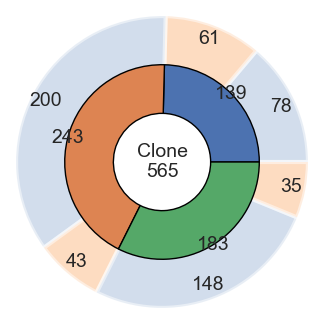

chain
IGK    243
IGL    183
IGH    139
Name: count, dtype: int64


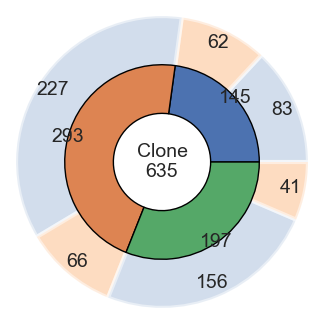

chain
IGK    293
IGL    197
IGH    145
Name: count, dtype: int64


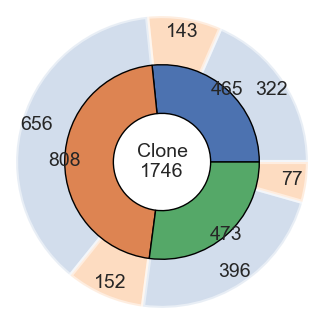

chain
IGK    808
IGL    473
IGH    465
Name: count, dtype: int64


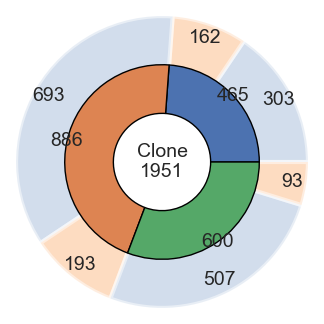

chain
IGK    886
IGL    600
IGH    465
Name: count, dtype: int64


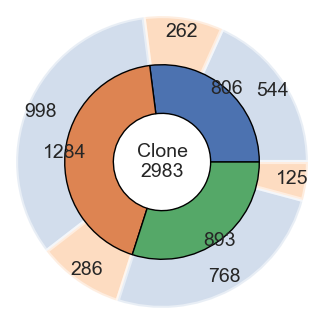

chain
IGK    1284
IGL     893
IGH     806
Name: count, dtype: int64


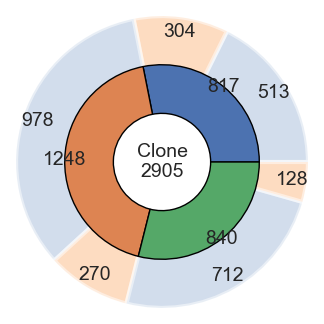

chain
IGK    1248
IGL     840
IGH     817
Name: count, dtype: int64


In [8]:
for sample,imudata in imudatadict.items():
    t = imudata.var.copy()
    t['mutated'] = (t['mutation']==0).map({True:'mutated',False:'germline'})
    t = t[t['chain'].isin(['IGK','IGL','IGH'])].copy()
    df = t[['chain','mutated']].astype(str)
    out_list = []
    in_list = []
    labels = []
    for idx,tmp in df.groupby('chain'):
        in_list.append(tmp['mutated'].count())
        for value in tmp['mutated'].value_counts():
            out_list.append(value)
        labels.append(idx)

    value_counts = df['chain'].value_counts()
    value_counts = value_counts.loc[['IGK','IGL','IGH']]
    sizes = value_counts.values
    def absolute_value(pct):
        total = sum(sizes)
        return int(round(pct*total/100.0))
    inner_colors = np.array(sns.color_palette('deep')[0:3])
    outer_colors = np.array([[166,189,219],[253,187,132],[166,189,219],[253,187,132],[166,189,219],[253,187,132]])/255
    fig,ax = plt.subplots(figsize = (4,4))
    ax.pie(out_list,autopct=lambda p: f'{absolute_value(p)}',radius=1.2,pctdistance=0.9,wedgeprops=dict(linewidth=3,width=0.5,edgecolor='w',alpha = 0.5),colors = outer_colors)
    ax.pie(in_list,autopct=lambda p: f'{absolute_value(p)}',radius=0.8,pctdistance=1,wedgeprops=dict(linewidth=1,width=0.4,edgecolor='black'),colors= inner_colors)
    count = t['chain'].count()
    ax.text(0, 0, f'Clone\n{count}', ha='center', va='center')
    plt.savefig(f'./figures/{sample}.distribution.pdf', bbox_inches='tight', dpi=400)
    plt.show()
    print(value_counts)

# 边界识别

## F1

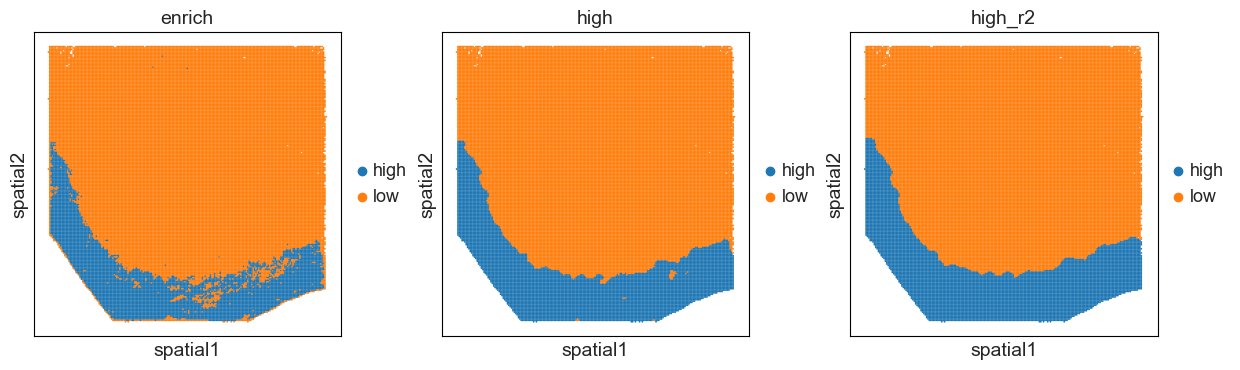

In [9]:
imudata = imudatadict['F1']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 3
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 20)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.9)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

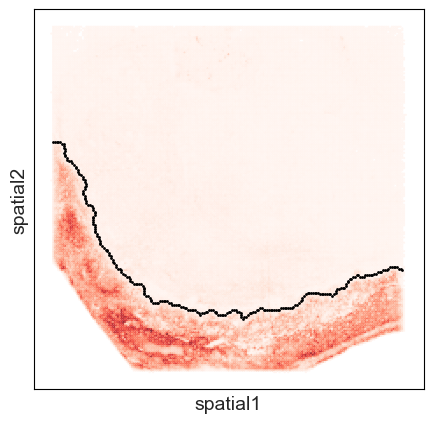

In [10]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']
fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.show()

In [11]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

## F3

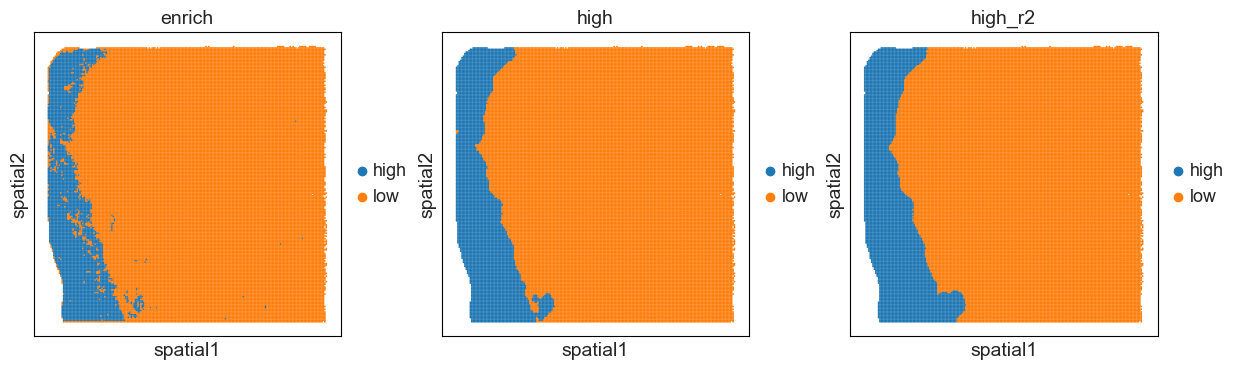

In [12]:
imudata = imudatadict['F3']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 3
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 40)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.88)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

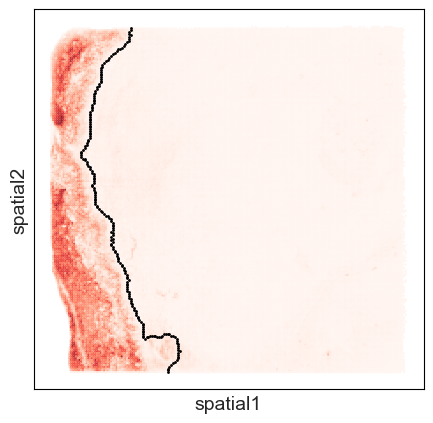

In [13]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.show()

In [14]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

## C1

In [15]:
imudatadict.keys()

dict_keys(['F1', 'F3', 'C1', 'D5', 'A3', 'C3'])

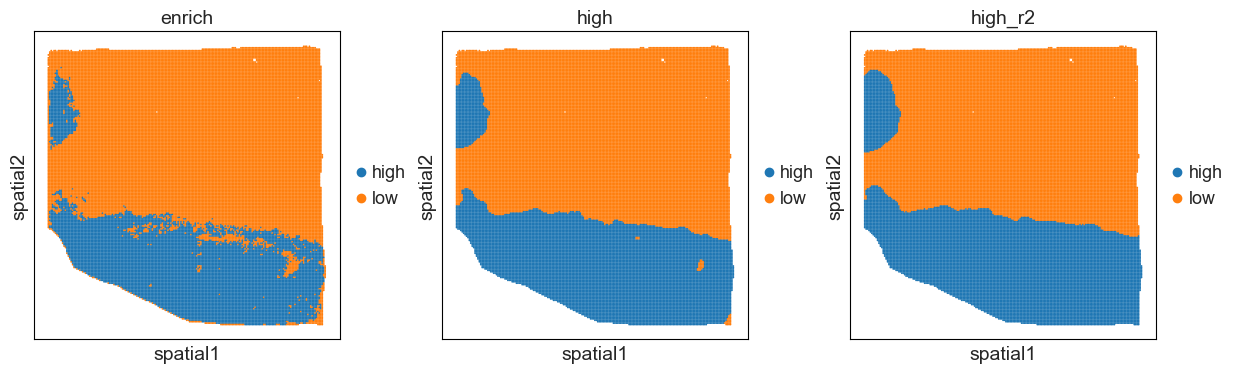

In [16]:
imudata = imudatadict['C1']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 4
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 40)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.88)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

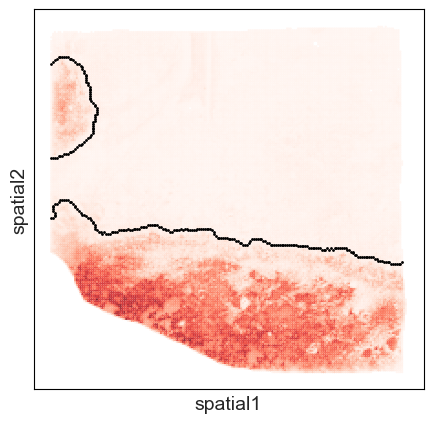

In [17]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.show()

In [18]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

## D5

In [19]:
imudatadict.keys()

dict_keys(['F1', 'F3', 'C1', 'D5', 'A3', 'C3'])

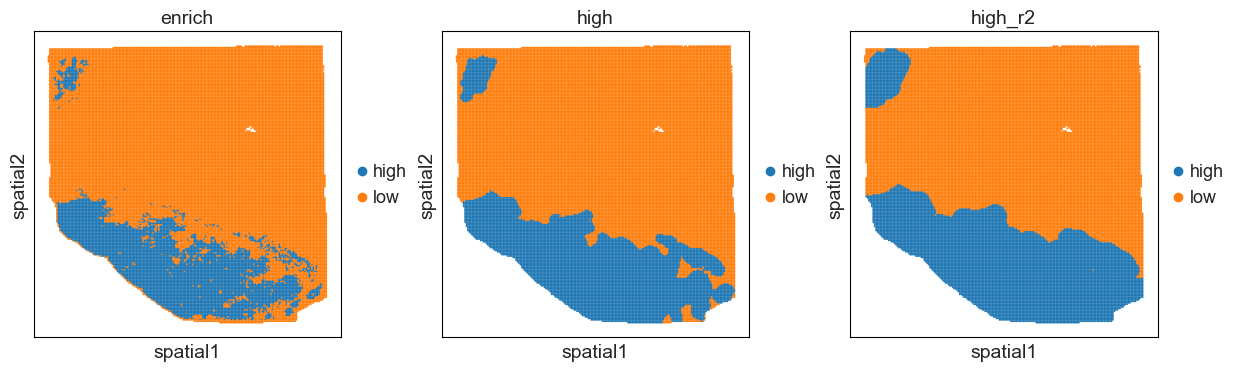

In [20]:
imudata = imudatadict['D5']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 2
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 60)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.99)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

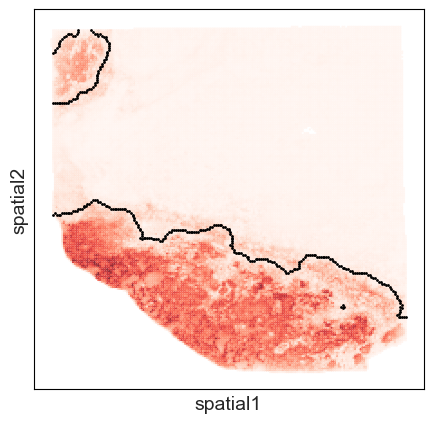

In [21]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.show()

In [22]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

## A3

In [23]:
imudatadict.keys()

dict_keys(['F1', 'F3', 'C1', 'D5', 'A3', 'C3'])

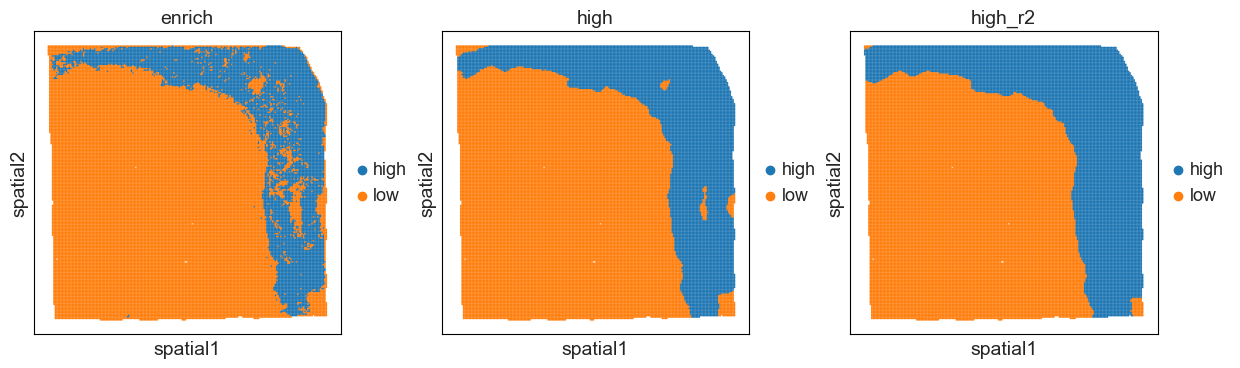

In [24]:
imudata = imudatadict['A3']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 2
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 40)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.99)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

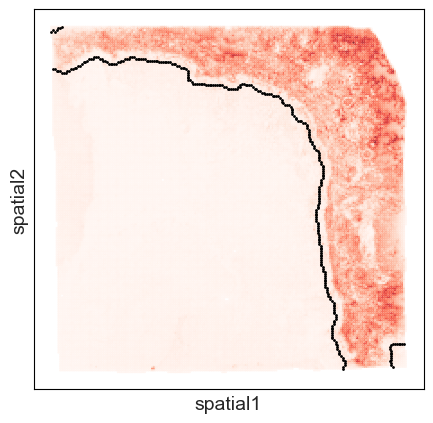

In [25]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.savefig('./figures/a3.boundary.pdf')
fig.show()

In [26]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

## C3

In [27]:
imudatadict.keys()

dict_keys(['F1', 'F3', 'C1', 'D5', 'A3', 'C3'])

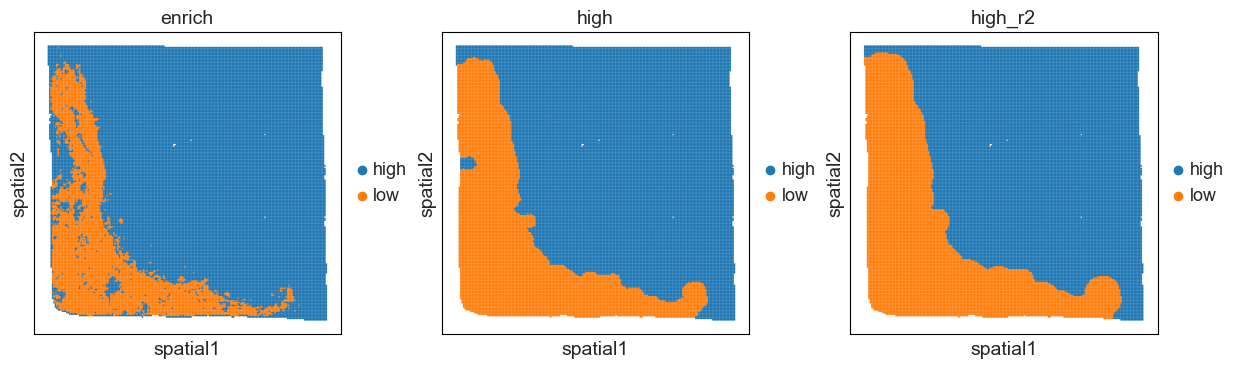

In [28]:
imudata = imudatadict['C3']
tb_counts = imudata.obs['total_counts'].values.reshape(-1, 1)
k = 2
kmeans = KMeans(n_clusters=k, random_state=61)
clusters = kmeans.fit_predict(tb_counts)
imudata.obs['enrich'] = clusters
imudata.obs['enrich'] = imudata.obs['enrich'].apply(lambda x: 'low' if x == 0 else 'high')
annodict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['enrich']))
cdr3loc = imudata.obsm['spatial']
tree = KDTree(cdr3loc)
query = tree.query(cdr3loc, k = 80)
distance,roundspot = query
roundspot_anno = [ [annodict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.05)
    results.append(result)
imudata.obs['high'] = results
anno_2_dict = dict(zip(range(imudata.obs.shape[0]),imudata.obs['high']))
roundspot_anno = [ [anno_2_dict[spot] for spot in spots]  for spots in roundspot]
results = []
for lst in roundspot_anno:
    result = is_majority_high(lst,x = 0.05)
    results.append(result)
imudata.obs['high_r2'] = results
sc.pl.spatial(imudata,color = ['enrich','high','high_r2'],basis = 'spatial',spot_size = 130,cmap = 'Reds')

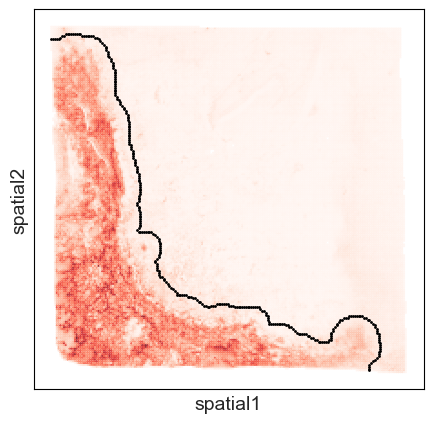

In [29]:
inner = imudata[imudata.obs['high_r2'] == 'low'].obsm['spatial']
outer = imudata[imudata.obs['high_r2'] == 'high'].obsm['spatial']
tree = KDTree(inner)
distance,nearesetspot = tree.query(outer, k = 1)
outsite_list = []
for idx, dist in enumerate(distance):
    if dist <= 100 + 10 and dist >= 100 - 10:
        outsite_list.append(idx)
border_cells = imudata[imudata.obs['high_r2'] == 'high'].obs.iloc[outsite_list].index
imudata.obs['border'] = imudata.obs_names.isin(border_cells)
border = imudata[imudata.obs['border']].obsm['spatial']

fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(data = imudata.obs, x = 'x', y = 'y',rasterized = True , s = 0.25 , c = 'total_counts',cmap = 'Reds')
ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('spatial1')
ax.set_ylabel('spatial2')
ax.set_xticks([]) 
ax.set_yticks([]) 
fig.savefig('./figures/c3.boundary.pdf')
fig.show()

In [30]:
tree = KDTree(border)
obsdf = pd.DataFrame(imudata.obsm['spatial'],index = imudata.obs_names, columns = ['x','y'])
obsdf['high_r2'] = imudata.obs['high_r2']
distance,idxs = tree.query(obsdf[['x','y']],k = 1)
obsdf['distance'] = distance
obsdf['sign'] = obsdf['high_r2'].map(lambda x:  -1 if x in ['high'] else 1)
obsdf['abs_distance'] = obsdf['sign'].astype(int) * obsdf['distance']
imudata.obs['distance'] = obsdf['abs_distance']

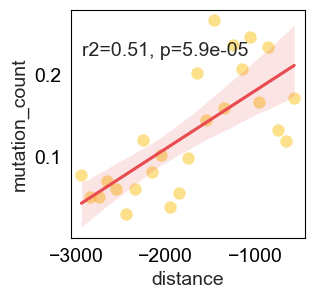

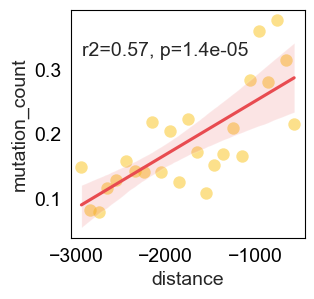

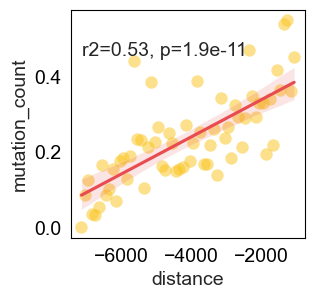

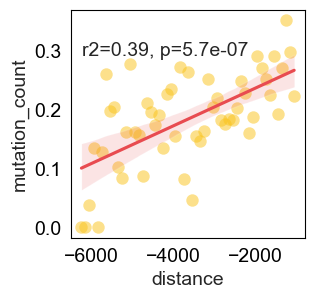

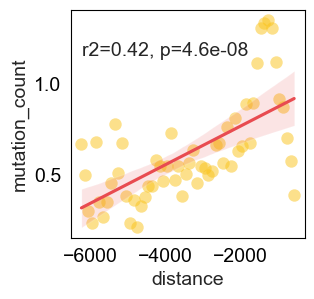

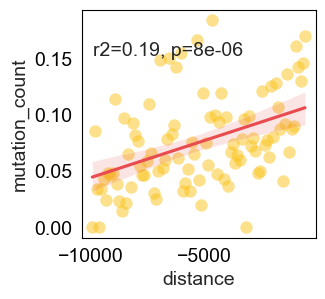

In [31]:
distance_range = {
    'F1':(-500,-3000),  
    'F3':(-500,-3000), 
    'C1':(-1000,-10000),
    'D5':(-1000,-10000),   
    'A3':(-500,-10000), 
    'C3':(-500,-10000)
}

for sample,imudata in imudatadict.items():
    max_distance,min_distance = distance_range[sample]
    obsdf = imudata.obs[['distance','mutation_count']].copy()
    obsdf = obsdf[(obsdf['distance'] < max_distance) & (obsdf['distance'] > min_distance)].copy()
    step = 100
    obsdf['dist_range'] = obsdf['distance']//step * step
    df_mean = obsdf.groupby('dist_range').mean().reset_index()
    pearsonr_corr, p_value = pearsonr(df_mean['distance'], df_mean['mutation_count'])
    fig,ax = plt.subplots(figsize = (3,3))
    regplot(df_mean,x = 'distance',y = 'mutation_count',ax =ax)
    fig.savefig(f'./figures/{sample}.mudistance.pdf')
    fig.show()

# Spatial Plot

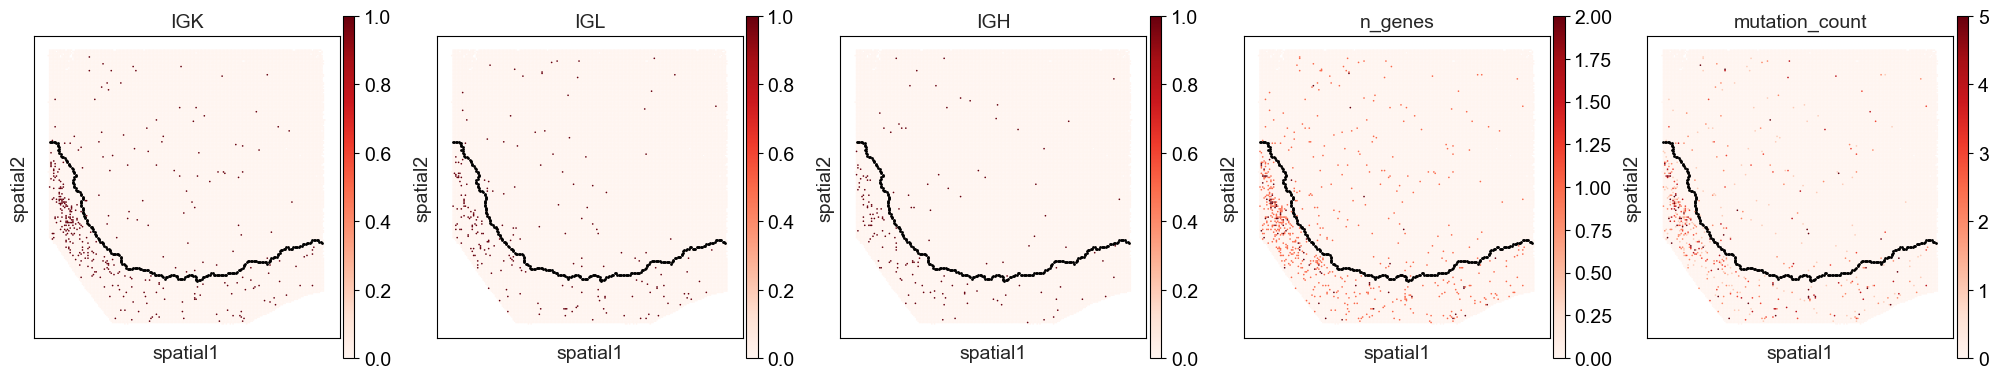

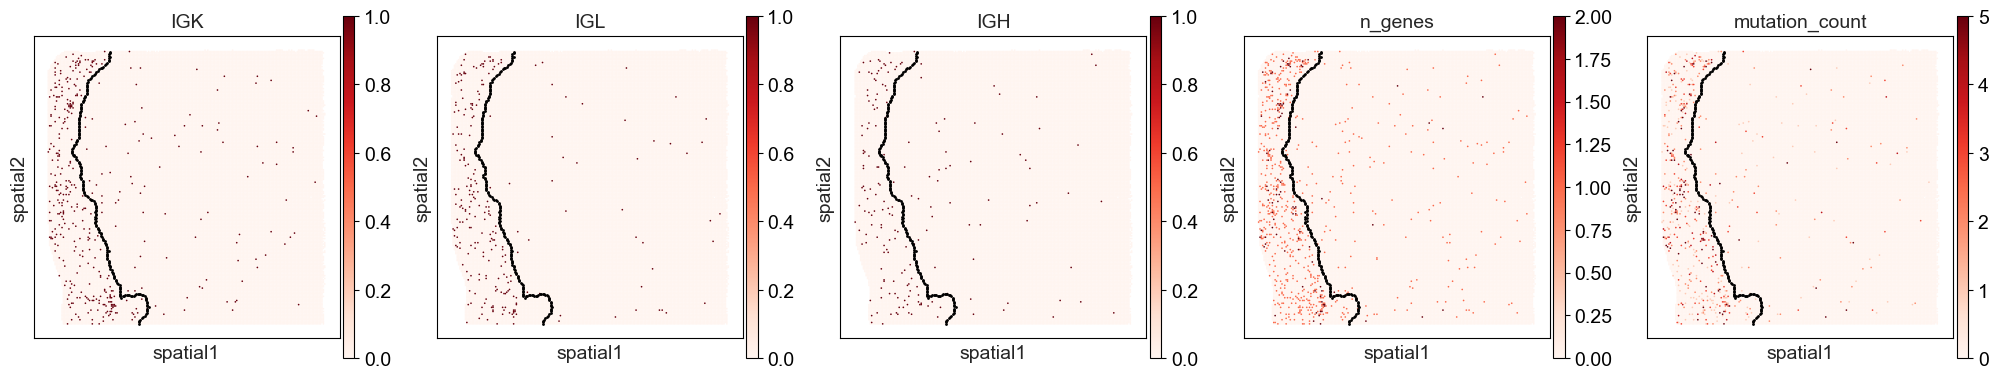

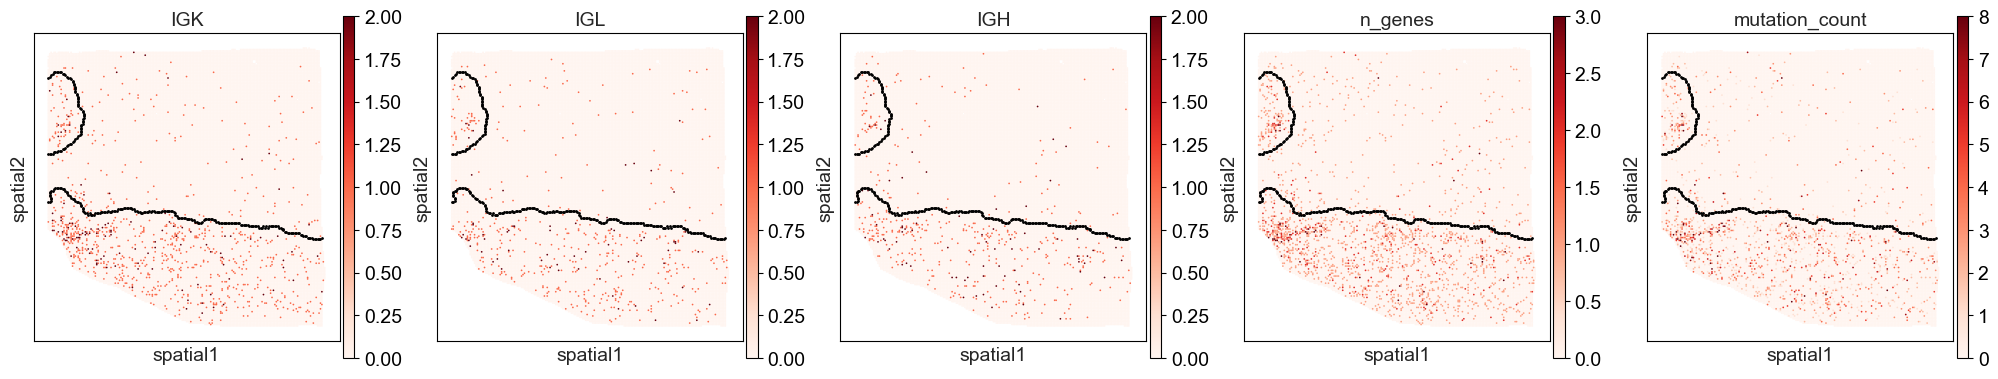

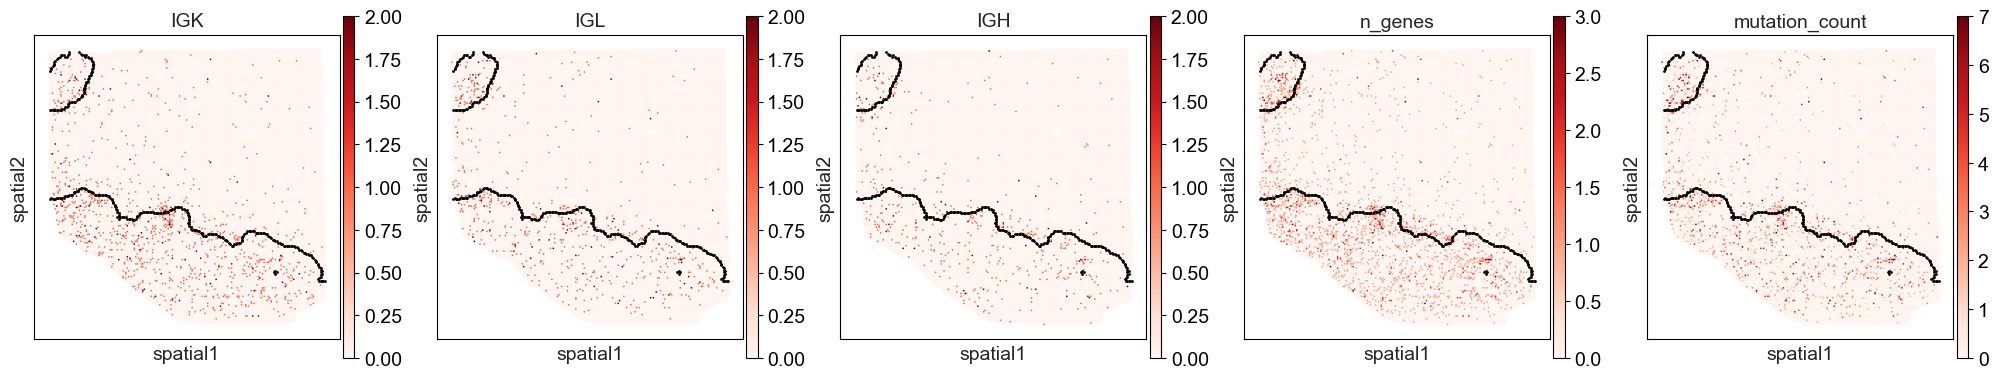

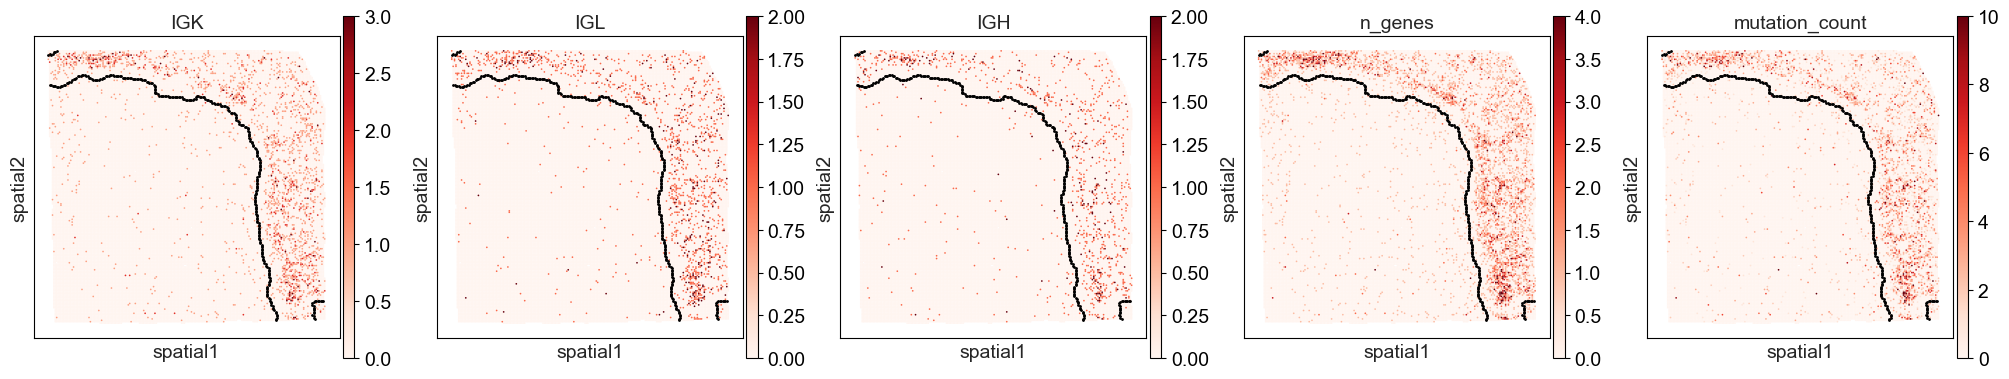

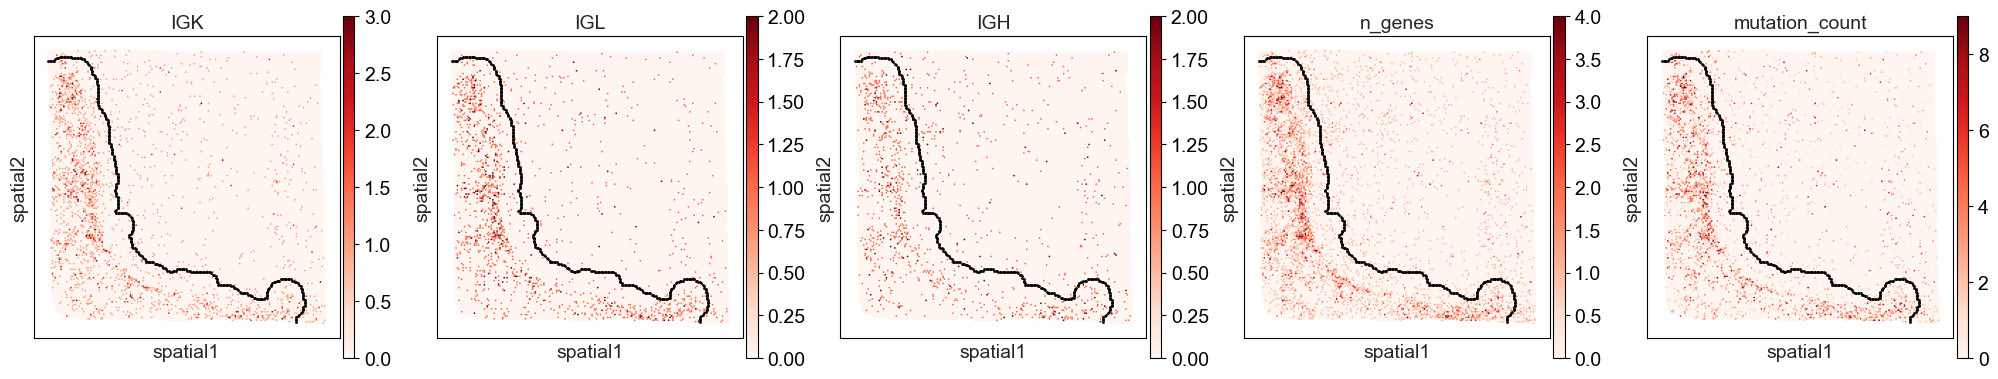

In [32]:
for sample,imudata in imudatadict.items():
    border = imudata[imudata.obs['border']].obsm['spatial']
    fig,axs = plt.subplots(1,5,figsize = (25,4.5))
    for idx,plot_ele in enumerate(['IGK','IGL','IGH','n_genes','mutation_count']):
        ax = axs[idx]
        sc.pl.spatial(imudata,color = plot_ele,basis = 'spatial',spot_size = 120,title = plot_ele,ax = ax,vmax = 'p99.9',show = False,cmap = 'Reds')
        ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
    fig.savefig(f'./figures/{sample}.spatial.pdf')
    fig.show()

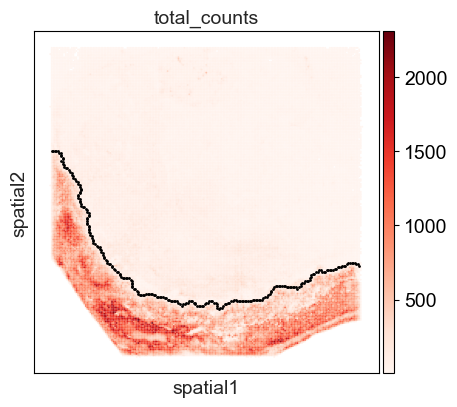

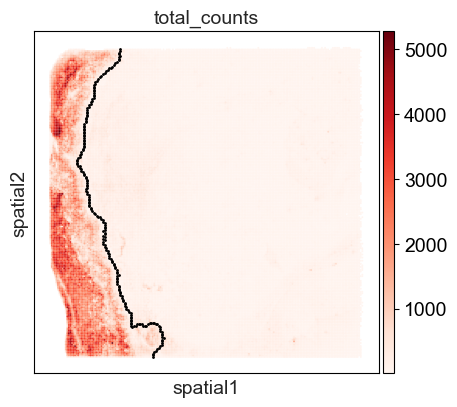

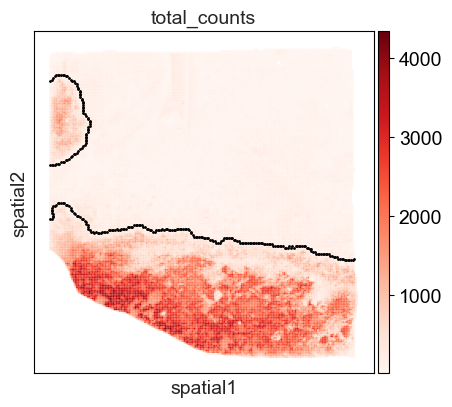

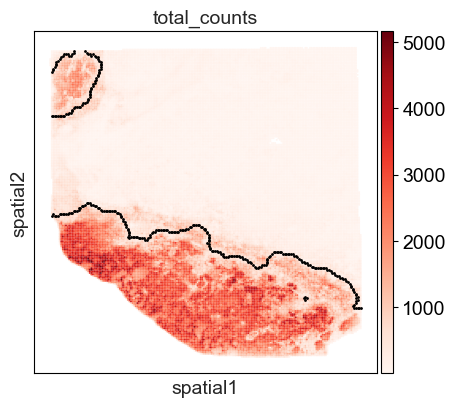

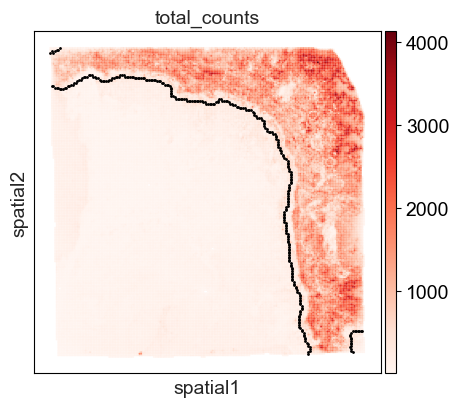

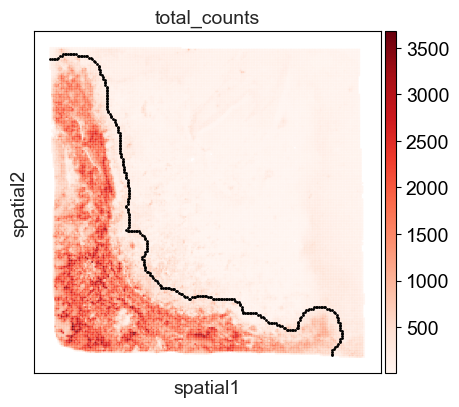

In [75]:
for sample,imudata in imudatadict.items():
    border = imudata[imudata.obs['border']].obsm['spatial']
    fig,ax = plt.subplots(1,1,figsize = (5,4.5))
    for idx,plot_ele in enumerate(['total_counts']):
        sc.pl.spatial(imudata,color = plot_ele,basis = 'spatial',spot_size = 120,title = plot_ele,ax = ax,show = False,cmap = 'Reds')
        ax.scatter(x = border[:,0], y = border[:,1],rasterized =True , s = 1 , color = 'black')
    fig.savefig(f'./figures/{sample}.total_counts.pdf')
    fig.show()

# common clone

In [33]:
p0clone = set(imudatadict['F1'].var_names) | set(imudatadict['F3'].var_names)
p1clone = set(imudatadict['C1'].var_names) | set(imudatadict['D5'].var_names)
p2clone = set(imudatadict['A3'].var_names) | set(imudatadict['C3'].var_names)

In [34]:
intissuep0contig = p0contig[p0contig['cloneId'].astype(str).isin(p0clone)].copy()
intissuep1contig = p1contig[p1contig['cloneId'].astype(str).isin(p1clone)].copy()
intissuep2contig = p2contig[p2contig['cloneId'].astype(str).isin(p2clone)].copy()

In [35]:
for contig in [intissuep0contig,intissuep1contig,intissuep2contig]:
    contig['Vgene'] = contig['allVHitsWithScore'].map(lambda x: x.split('(')[0])
    contig['Jgene'] = contig['allJHitsWithScore'].map(lambda x: x.split('(')[0])
    contig['clonename'] = contig['aaSeqCDR3'] + '@' + contig['Vgene'] + '@' + contig['Jgene']

In [36]:
cloneset = {
    'p0': set(intissuep0contig['clonename']),
    'p1': set(intissuep1contig['clonename']),
    'p2': set(intissuep2contig['clonename']),
}

In [37]:
from venn import venn

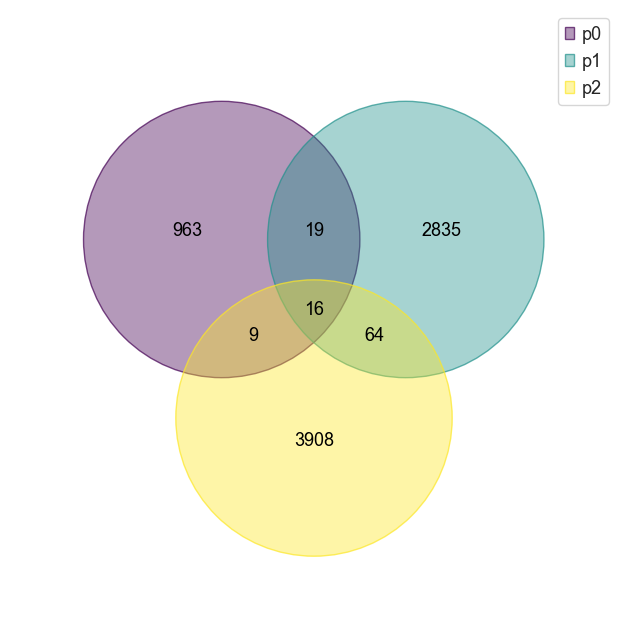

In [38]:
venn(cloneset)
plt.savefig('./figures/common.pdf')

In [39]:
common_clones = set.intersection(*cloneset.values())

In [40]:
common_clones

{'CMQALQTPYTF@IGKV2D-28*00@IGKJ2*00',
 'CMQGTHWPYTF@IGKV2-30*00@IGKJ2*00',
 'CQQSYSTPLTF@IGKV1-39*00@IGKJ4*00',
 'CQQSYSTPWTF@IGKV1-39*00@IGKJ1*00',
 'CQQSYSTPYTF@IGKV1-39*00@IGKJ2*00',
 'CQQSYTTPWTF@IGKV1-39*00@IGKJ1*00',
 'CQQYGSSPLFTF@IGKV3-20*00@IGKJ3*00',
 'CQQYGSSPPWTF@IGKV3-20*00@IGKJ1*00',
 'CQQYGSSPPYTF@IGKV3-20*00@IGKJ2*00',
 'CQQYGSSPRTF@IGKV3-20*00@IGKJ1*00',
 'CQQYGSSPWTF@IGKV3-20*00@IGKJ1*00',
 'CQQYGSSPYTF@IGKV3-20*00@IGKJ2*00',
 'CQQYNNWPPWTF@IGKV3-15*00@IGKJ1*00',
 'CQQYNNWPRTF@IGKV3-15*00@IGKJ1*00',
 'CQQYNNWPYTF@IGKV3-15*00@IGKJ2*00',
 'CSSYTSSSTLVF@IGLV2-14*00@IGLJ1*00'}

# Tree

In [41]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram
from scipy.spatial.distance import squareform
import radialtree as rt
import Levenshtein
def cluster_strings(series):
    n = len(series)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = Levenshtein.distance(series[i], series[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    Z = linkage(squareform(dist_matrix), 'complete')

    return Z

from Bio.Align.Applications import ClustalwCommandline
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Align import AlignInfo
from Bio import AlignIO
import seqlogo

def align_seq(protein_sequences,out_prefix,max_lenth = None,plot = True,return_df = False,return_consensus = False):
    if max_lenth != None:
        protein_sequences = [i for i in protein_sequences if len(i) <= max_lenth]
    def write_fasta(sequences, filename="sequences.fasta"):
        seq_records = [SeqRecord(Seq(seq), id=f"Seq{i+1}", description="") for i, seq in enumerate(sequences)]
        SeqIO.write(seq_records, filename, "fasta")
        return filename
    fasta_file = write_fasta(protein_sequences)
    clustalw_exe = "/home/liuyi/02.software/clustalw/clustalw-2.1-linux-x86_64-libcppstatic/clustalw2"
    clustalw_cline = ClustalwCommandline(clustalw_exe, infile=fasta_file)
    clustalw_cline()
    alignments = AlignIO.read("sequences.aln", "clustal")
    alignment_list = []
    for alignment in alignments:
        alignment_list.append(str(alignment.seq))
    
    # skip -
    from collections import Counter
    length = len(alignment_list[0])
    columns = [[] for _ in range(length)]
    for seq in alignment_list:
        for i, char in enumerate(seq):
            columns[i].append(char)
    most_common_chars = [Counter(col).most_common(1)[0][0] for col in columns]
    filtered_columns = [col for col, char in zip(columns, most_common_chars) if char != '-']
    alignment_list = [''.join(col) for col in zip(*filtered_columns)]
    
    if return_df:
        return pd.DataFrame(alignment_list)
    if return_consensus:
        return plot_seqlogo(alignment_list,return_consensus = True)
    else:
        pd.DataFrame(alignment_list).to_csv(f'./aa_seqlogo/{out_prefix}.csv',index=None,header=None)
    if plot:
        image = plot_seqlogo(alignment_list)
        return image

def plot_seqlogo(seqs,return_consensus = False):
    seqs = [ seq.replace('-','_') for seq in seqs]
    amino_acids = "ACDEFGHIKLMNPQRSTVWYX*_"
    freq_matrix = {aa: [0] * len(seqs[0]) for aa in amino_acids}
    for seq in seqs:
        for i, aa in enumerate(seq):
            if aa in freq_matrix:
                freq_matrix[aa][i] += 1
    total_seqs = len(seqs)
    freq_matrix = {aa: [count/total_seqs for count in counts] for aa, counts in freq_matrix.items()}
    freq_df = pd.DataFrame(freq_matrix, index=range(1, len(seqs[0])+1))
    FreqSeqLogo= seqlogo.Ppm(freq_df,alphabet_type="reduced AA",background = 0.1)
    if return_consensus:
        consensus = ""
        for i in range(FreqSeqLogo.ppm.shape[0]):
            tmp = FreqSeqLogo.ppm.iloc[i]
            if tmp[tmp>0.5].shape[0] ==0:
                consensus += "X"
            else:
                base = tmp[tmp>0.5].index[0]
                consensus+=base
        return consensus
    image = seqlogo.seqlogo(FreqSeqLogo, ic_scale = False,format = 'png',size = 'small',color_scheme = 'monochrome')
    return image

def find_first_occurrences(labels):
    occurrences = {}
    last_label = None
    
    for idx, label in enumerate(labels):
        if label != last_label:
            if label not in occurrences:
                occurrences[label] = []
            occurrences[label].append(idx)
        last_label = label
    data = []
    for label, indices in occurrences.items():
        for idx in indices:
            data.append({'index': idx, 'label': label})
    df = pd.DataFrame(data)
    return df
import random
random.seed(62)
def getcolor_list(k):
    color_pal1 = [
    "#70f3ff", "#44cef6", "#3eede7", "#1685a9", "#177cb0", "#065279", "#003472",
    "#4b5cc4", "#a1afc9", "#2e4e7e", "#3b2e7e", "#4a4266", "#426666", "#425066",
    "#574266", "#8d4bbb", "#815463", "#815476", "#4c221b", "#003371", "#56004f",
    "#801dae", "#4c8dae", "#b0a4e3", "#cca4e3", "#edd1d8", "#e4c6d0", "#ff461f",
    "#ff2d51", "#f36838", "#ed5736", "#ff4777", "#f00056", "#ffb3a7", "#f47983",
    "#db5a6b", "#c93756", "#f9906f", "#f05654", "#ff2121", "#f20c00", "#8c4356",
    "#c83c23", "#9d2933", "#ff4c00", "#ff4e20", "#f35336", "#dc3023", "#ff3300",
    "#cb3a56", "#a98175", "#b36d61", "#ef7a82", "#ff0097", "#c32136", "#be002f",
    "#c91f37", "#bf242a", "#c3272b", "#9d2933", "#60281e", "#622a1d", "#bce672",
    "#c9dd22", "#bddd22", "#afdd22", "#a3d900", "#9ed900", "#9ed048", "#96ce54",
    "#00bc12", "#0eb83a", "#0eb83a", "#0aa344", "#16a951", "#21a675", "#057748",
    "#0c8918", "#00e500", "#40de5a", "#00e079", "#00e09e", "#3de1ad", "#2add9c",
    "#2edfa3", "#7fecad", "#a4e2c6", "#7bcfa6", "#1bd1a5", "#48c0a3", "#549688",
    "#789262", "#758a99", "#50616d", "#424c50", "#41555d", "#eaff56", "#fff143",
    "#faff72", "#ffa631", "#ffa400", "#fa8c35", "#ff8c31", "#ff8936", "#ff7500",
    "#ffb61e", "#ffc773", "#ffc64b", "#f2be45", "#f0c239", "#e9bb1d", "#d9b611",
    "#eacd76", "#eedeb0", "#d3b17d", "#e29c45", "#a78e44", "#c89b40", "#ae7000",
    "#ca6924", "#b25d25", "#b35c44", "#9b4400", "#9c5333", "#a88462", "#896c39",
    "#827100", "#6e511e", "#7c4b00", "#955539", "#845a33", "#ffcc99", "#ffaa66",
    "#ff8855", "#ff6677", "#cc99ff", "#99ccff", "#66ffcc", "#33ff99", "#00ff77",
    "#ffcc00", "#ff9900", "#ff6600", "#ff3300", "#cc0066", "#9900cc", "#6600ff",
    "#0066ff", "#00ccff", "#00ffcc", "#33ff66", "#66ff33", "#ccff00", "#ffff00",
    "#ffcc33", "#ff9966", "#ff6699", "#cc66ff", "#9966ff", "#6699ff", "#3399ff",
    "#00ccff", "#33ffff", "#66ffcc", "#99ff99", "#ccffcc", "#ffffcc", "#ffcccc",
    "#ffccff", "#ccccff", "#ccffff", "#111111", "#222222", "#333333", "#444444",
    "#555555", "#666666", "#777777", "#888888", "#999999", "#aaaaaa", "#bbbbbb",
    "#cccccc", "#dddddd", "#eeeeee"
]
    color_pal1 = list(set(color_pal1)) * 100
    def generate_color_list(colors, k, seed=61):
        random.seed(seed)
        color_list = random.sample(colors, k)
        while any(color_list[i] == color_list[i + 1] for i in range(len(color_list) - 1)):
            random.shuffle(color_list)
        return color_list
    color_lists = generate_color_list(color_pal1, k - 1)
    return color_lists

/home/liuyi/miniconda3/envs/spatial/lib/python3.9/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [42]:
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Circle
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

def radialTreee(
    Z2,
    fontsize=8,
    ax: Axes = None,
    pallete=None,
    addlabels=True,
    sample_classes=None,
    colorlabels=None,
    colorlabels_legend=None,
    alpha = 1,
    linewidth = 1,
    linecolor = 'black'
):

    if ax is None:
        ax: Axes = plt.gca()
    R = 1
    width = R * 0.05
    space = R * 0.01

    if colorlabels != None:
        offset = (
            width * len(colorlabels) / R + space * (len(colorlabels) - 1) / R + 0.05
        )
    elif sample_classes != None:
        offset = (
            width * len(sample_classes) / R
            + space * (len(sample_classes) - 1) / R
            + 0.05
        )
    else:

        offset = 0

    xmax = np.amax(Z2["icoord"])
    xmin = np.amin(Z2["icoord"])
    ymax = np.amax(Z2["dcoord"])
    
    ucolors = sorted(set(Z2["color_list"]), key=lambda x: int(x[1:]))

    if isinstance(pallete,str):
        cmap_colors = plt.get_cmap('Set2').colors
        cmap = dict()
        for i in range(len(ucolors)):
            cmap[i] = cmap_colors[i % len(cmap_colors)]
            
    elif isinstance(pallete,dict):
        cmap = pallete
    else:
        raise KeyError('cmap need to be a dict  [cluster, color]')
    
    nlabels = 0
    for icoord, dcoord, c in sorted(zip(Z2["icoord"], Z2["dcoord"], Z2["color_list"])):
        # x, y = Z2['icoord'][0], Z2['dcoord'][0]

        if c == "C0":  # np.abs(_xr1)<0.000000001 and np.abs(_yr1) <0.000000001:
            _color = linecolor
        else:
            _color  = cmap[int(c.split('C')[1])]

        # transforming original x coordinates into relative circumference positions and y into radius
        # the rightmost leaf is going to [1, 0]
        r = R * (1 - np.array(dcoord) / ymax)
        _x = np.cos(
            2 * np.pi * np.array([icoord[0], icoord[2]]) / xmax
        )  # transforming original x coordinates into x circumference positions
        _xr0 = _x[0] * r[0]
        _xr1 = _x[0] * r[1]
        _xr2 = _x[1] * r[2]
        _xr3 = _x[1] * r[3]
        _y = np.sin(
            2 * np.pi * np.array([icoord[0], icoord[2]]) / xmax
        )  # transforming original x coordinates into y circumference positions
        _yr0 = _y[0] * r[0]
        _yr1 = _y[0] * r[1]
        _yr2 = _y[1] * r[2]
        _yr3 = _y[1] * r[3]
        # ax.scatter([_xr0, _xr1, _xr2, _xr3],[_yr0, _yr1, _yr2,_yr3], c="b")

        # if y[0]>0 and y[3]>0:
        # _color="black"
        # plotting radial lines
        ax.plot([_xr0, _xr1], [_yr0, _yr1], c=_color, linewidth=linewidth,alpha = alpha)
        ax.plot([_xr2, _xr3], [_yr2, _yr3], c=_color, linewidth=linewidth,alpha = alpha)

        # plotting circular links between nodes
        if _yr1 > 0 and _yr2 > 0:
            link = np.sqrt(r[1] ** 2 - np.linspace(_xr1, _xr2, 100) ** 2)
            ax.plot(np.linspace(_xr1, _xr2, 100), link, c=_color, linewidth=linewidth,alpha = alpha)
        elif _yr1 < 0 and _yr2 < 0:
            link = -np.sqrt(r[1] ** 2 - np.linspace(_xr1, _xr2, 100) ** 2)

            ax.plot(np.linspace(_xr1, _xr2, 100), link, c=_color, linewidth=linewidth,alpha = alpha)
        elif _yr1 > 0 and _yr2 < 0:
            _r = r[1]
            if _xr1 < 0 or _xr2 < 0:
                _r = -_r
            link = np.sqrt(r[1] ** 2 - np.linspace(_xr1, _r, 100) ** 2)
            ax.plot(np.linspace(_xr1, _r, 100), link, c=_color, linewidth=linewidth,alpha = alpha)
            link = -np.sqrt(r[1] ** 2 - np.linspace(_r, _xr2, 100) ** 2)
            ax.plot(np.linspace(_r, _xr2, 100), link, c=_color, linewidth=linewidth,alpha = alpha)

    label_coords = []
    # determine the coordiante of the labels and their rotation:
    for i, label in enumerate(Z2["ivl"]):
        # scipy (1.x.x) places the leaves in x = 5+i*10 , and we can use this
        # to calulate where to put the labels
        place = (5.0 + i * 10.0) / xmax * 2
        label_coords.append(
            [
                np.cos(place * np.pi) * (1.05 + offset),  # _x
                np.sin(place * np.pi) * (1.05 + offset),  # _y
                place * 180,  # _rot
            ]
        )
    if addlabels == True:
        assert len(Z2["ivl"]) == len(label_coords), (
            f'Internal error, label numbers for Z2 ({len(Z2["ivl"])})'
            f" and for calculated labels ({len(label_coords)}) must be equal!"
        )
        for (_x, _y, _rot), label in zip(label_coords, Z2["ivl"]):
            ax.text(
                _x,
                _y,
                label,
                {"va": "center"},
                rotation_mode="anchor",
                rotation=_rot,
                fontsize=fontsize,
            )

    if colorlabels != None:
        assert len(Z2["ivl"]) == len(label_coords), (
            "Internal error, label numbers "
            + str(len(Z2["ivl"]))
            + " and "
            + str(len(label_coords))
            + " must be equal!"
        )
        j = 0
        outerrad = R * 1.05 + width * len(colorlabels) + space * (len(colorlabels) - 1)
        intervals = []
        for i in range(len(label_coords)):
            _xl, _yl, _rotl = label_coords[i - 1]
            _x, _y, _rot = label_coords[i]
            if i == len(label_coords) - 1:
                _xr, _yr, _rotr = label_coords[0]
            else:
                _xr, _yr, _rotr = label_coords[i + 1]
            d = ((_xr - _xl) ** 2 + (_yr - _yl) ** 2) ** 0.5
            intervals.append(d)
        colorpos = intervals  # np.ones([len(label_coords)])
        labelnames = []
        m=0

        for labelname, colorlist in colorlabels.items():

            colorlist = np.array(colorlist)[Z2["leaves"]]
            outerrad = outerrad - width * j - space * j
            innerrad = outerrad - width
            patches, texts = ax.pie(
                colorpos,
                colors = colorlist,
                radius = outerrad,
                counterclock = True,
                startangle = label_coords[0][2] * 0.5,
                wedgeprops=dict(
                    width=width,
                    # edgecolor='w', #if this is active the wedges will be more clearly separated
                ),
            )
            labelnames.append(labelname)
            j += 1


        if colorlabels_legend != None:
            for i, labelname in enumerate(labelnames):
                colorlines = []
                for c in colorlabels_legend[labelname]["colors"]:
                    colorlines.append(Line2D([0], [0], color=c, lw=4))
                leg = ax.legend(
                    colorlines,
                    colorlabels_legend[labelname]["labels"],
                    bbox_to_anchor=(1.5 + 0.3 * i, 1.0),
                    title=labelname,
                )
                ax.add_artist(leg)
    elif sample_classes != None:
        assert len(Z2["ivl"]) == len(label_coords), (
            "Internal error, label numbers "
            + str(len(Z2["ivl"]))
            + " and "
            + str(len(label_coords))
            + " must be equal!"
        )

        j = 0
        outerrad = (
            R * 1.05 + width * len(sample_classes) + space * (len(sample_classes) - 1)
        )

        # sort_index=np.argsort(Z2['icoord'])
        # print(sort_index)
        intervals = []
        for i in range(len(label_coords)):
            _xl, _yl, _rotl = label_coords[i - 1]
            _x, _y, _rot = label_coords[i]
            if i == len(label_coords) - 1:
                _xr, _yr, _rotr = label_coords[0]
            else:
                _xr, _yr, _rotr = label_coords[i + 1]
            d = ((_xr - _xl) ** 2 + (_yr - _yl) ** 2) ** 0.5
            intervals.append(d)
        colorpos = intervals  # np.ones([len(label_coords)])
        labelnames = []
        colorlabels_legend = {}


        for labelname, colorlist in sample_classes.items():
            ucolors = sorted(list(np.unique(colorlist)))
            type_num = len(ucolors)
            _cmp = cm.get_cmap(colormap_list[j], type_num)
            _colorlist = [_cmp(ucolors.index(c)) for c in colorlist]
            _colorlist = np.array(_colorlist)[Z2["leaves"]]
            outerrad = outerrad - width * j - space * j
            innerrad = outerrad - width
            patches, texts = ax.pie(
                colorpos,
                colors=_colorlist,
                radius=outerrad,
                counterclock=True,
                startangle=label_coords[0][2] * 0.5,
                wedgeprops=dict(
                    width=width,
                    # edgecolor='w', #if this is active the wedges will be more clearly separated
                ),
            )


            labelnames.append(labelname)
            colorlabels_legend[labelname] = {}
            colorlabels_legend[labelname]["colors"] = _cmp(np.linspace(0, 1, type_num))
            colorlabels_legend[labelname]["labels"] = ucolors
            j += 1
        if colorlabels_legend != None:
            for i, labelname in enumerate(labelnames):
#                 print(colorlabels_legend[labelname]["colors"])
                colorlines = []
                for c in colorlabels_legend[labelname]["colors"]:
                    colorlines.append(Line2D([0], [0], color=c, lw=4))
                leg = ax.legend(
                    colorlines,
                    colorlabels_legend[labelname]["labels"],
                    bbox_to_anchor=(1.5 + 0.3 * i, 1.0),
                    title=labelname,
                )
                ax.add_artist(leg)
            # break
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if colorlabels != None:
        maxr = R * 1.05 + width * len(colorlabels) + space * (len(colorlabels) - 1)
    elif sample_classes != None:
        maxr = (
            R * 1.05 + width * len(sample_classes) + space * (len(sample_classes) - 1)
        )
    else:
        maxr = R * 1.05
    ax.set_xlim(-maxr, maxr)
    ax.set_ylim(-maxr, maxr)
    return ax

In [43]:
chain = 'IGK'
clonedf = []
for imudata in imudatadict.values():
    subdata = imudata[:,imudata.var['chain']== chain]
    clonedf_tmp = subdata.var['CDR3'].drop_duplicates().to_frame().copy()
    clonedf.append(clonedf_tmp)
clonedf = pd.concat(clonedf)
clonedf = clonedf.drop_duplicates(['CDR3'])

In [44]:
Z = cluster_strings(clonedf['CDR3'])

/tmp/ipykernel_1446503/102980250.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = Levenshtein.distance(series[i], series[j])


In [45]:
threshold = 6
clusters = fcluster(Z, threshold, criterion='distance')
rZ = dendrogram(Z,no_plot=True,color_threshold= threshold+0.1,labels=clonedf['CDR3'].to_list())
clonedf['cluster'] = clusters

In [46]:
vc = clonedf['cluster'].value_counts()
onlyonecluster = vc[vc == 1].index
color_list = getcolor_list(k = max(clusters)+1)
cluster_color_dict = {}
legend_color_dict = {}
bias = 0
for idx,cluster in enumerate(vc.sort_index().index):
    if cluster in onlyonecluster:
        bias += 1
        legend_color_dict[cluster] = 'black'
        continue
    cluster_color_dict[cluster - bias] = color_list[idx]
    legend_color_dict[cluster] = color_list[idx]
before = ""
result_list = []
counter = {'C1': -1, 'C2': -1, 'C3': -1, 'C4': -1, 'C5': -1, 'C6': -1, 'C7': -1, 'C8': -1, 'C9': -1}
step_C = 0
for now in rZ['color_list']:
    if now == 'C0':
        result_list.append(now)
    else:
        if now != before:
            step_C += 1
        result_list.append(f'C{step_C}')
        before = now
rZ['color_list'] = result_list
plot_colors_dict = {
    'cluster_type':np.array(clonedf['cluster'].map(legend_color_dict).tolist())
                   }

plot_colors_legends = {
                        'cluster_type':
                        {'colors':np.array(list(legend_color_dict.values())),'labels':list(legend_color_dict.keys())}
                      }

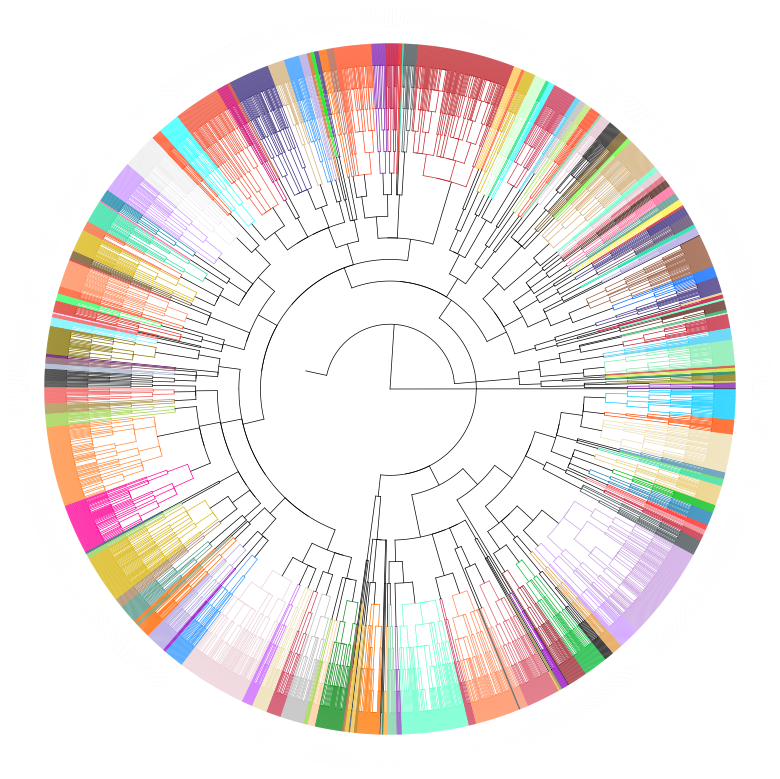

In [47]:
fig,ax = plt.subplots(figsize = (10,10))
radialTreee(rZ,ax = ax,colorlabels = plot_colors_dict,colorlabels_legend =plot_colors_legends,pallete = cluster_color_dict,addlabels =False,alpha = 1,linewidth = 0.5)
fig.savefig('./figures/tbhuman.st.tree.pdf')
fig.show()

# get htb from pulic data

In [48]:
from glob import glob
meta = pd.read_csv('/storage/liuyi/08.stereo_v2/human_tb/meta.csv')
metadict = dict(zip(meta['Run'],meta['Group']))
sra_paths = glob('/media/transport2/hTB_RNA-seq/mixcr/SRR*')
total_result = {}
for sra_path in sra_paths:
    sra_name = sra_path.split('/')[-1]
    contig_file = sra_path + '/' + sra_name + ".contigs.tsv"
    try:
        contig = pd.read_csv(contig_file,sep = '\t')
        contig['Vgene'] = contig['allVHitsWithScore'].map(lambda x: x.split('(')[0])
        contig['Jgene'] = contig['allJHitsWithScore'].map(lambda x: x.split('(')[0])
        contig['clonename'] = contig['aaSeqCDR3'] + '@' + contig['Vgene'] + '@' + contig['Jgene']
#         contig['read_count_p'] = contig['readCount']/contig['readCount'].sum()
        contig['group'] = metadict[sra_name]
        contig['p'] = sra_name
        if contig.shape[0] >=500:
            total_result[sra_name] = contig
        else:
            print(f"{sra_name} clone not < 500")
    except:
        pass
    
total_contig = pd.concat(total_result.values())
total_contig = total_contig[total_contig['topChains'].isin(['IGK'])].copy()
clonecount = total_contig.groupby('clonename')['p'].nunique().sort_values(ascending=False)
total_contig = total_contig[total_contig['clonename'].isin(clonecount[clonecount > 5].index)]  
pbmcdf = []
for p in np.unique(total_contig['p']):
    ptotaldf = total_contig[total_contig['p'] == p].copy()
    ptotaldf['read_count_p'] = ptotaldf['readCount']/ptotaldf['readCount'].sum()
    pbmcdf.append(ptotaldf)
pbmcdf = pd.concat(pbmcdf)

SRR6370062 clone not < 500
SRR6370064 clone not < 500
SRR6370022 clone not < 500
SRR6370024 clone not < 500
SRR6370036 clone not < 500
SRR6370041 clone not < 500
SRR6370050 clone not < 500
SRR6370114 clone not < 500
SRR6370143 clone not < 500
SRR6370157 clone not < 500
SRR6370164 clone not < 500


In [49]:
pbmcdf['func'] = pbmcdf['aaSeqCDR3'].map(lambda x :  'nofunc' if '_' in x or '*' in x else 'func')
pbmcdf = pbmcdf[pbmcdf['func'] == 'func'].copy()
pbmccdr3df = pbmcdf.drop_duplicates('aaSeqCDR3').copy()
chainpbmccdr3df = pbmccdr3df[pbmccdr3df['topChains'] == chain].copy()
chainpbmccdr3df = chainpbmccdr3df.sort_values('aaSeqCDR3',ascending=False)

In [50]:
Z = cluster_strings(chainpbmccdr3df['aaSeqCDR3'].tolist())
threshold = 5
clusters = fcluster(Z, threshold, criterion='distance')
rZ = dendrogram(Z,no_plot=True,color_threshold= threshold+0.1,labels=chainpbmccdr3df['aaSeqCDR3'].to_list())
chainpbmccdr3df['cluster'] = clusters

In [51]:
vc = chainpbmccdr3df['cluster'].value_counts()
onlyonecluster = vc[vc == 1].index
color_list = getcolor_list(k = max(clusters)+1)
cluster_color_dict = {}
legend_color_dict = {}
bias = 0
for idx,cluster in enumerate(vc.sort_index().index):
    if cluster in onlyonecluster:
        bias += 1
        legend_color_dict[cluster] = 'black'
        continue
    cluster_color_dict[cluster - bias] = color_list[idx]
    legend_color_dict[cluster] = color_list[idx]
before = ""
result_list = []
counter = {'C1': -1, 'C2': -1, 'C3': -1, 'C4': -1, 'C5': -1, 'C6': -1, 'C7': -1, 'C8': -1, 'C9': -1}
step_C = 0
for now in rZ['color_list']:
    if now == 'C0':
        result_list.append(now)
    else:
        if now != before:
            step_C += 1
        result_list.append(f'C{step_C}')
        before = now
rZ['color_list'] = result_list
plot_colors_dict = {
    'cluster_type':np.array(chainpbmccdr3df['cluster'].map(legend_color_dict).tolist())
                   }

plot_colors_legends = {
                        'cluster_type':
                        {'colors':np.array(list(legend_color_dict.values())),'labels':list(legend_color_dict.keys())}
                      }

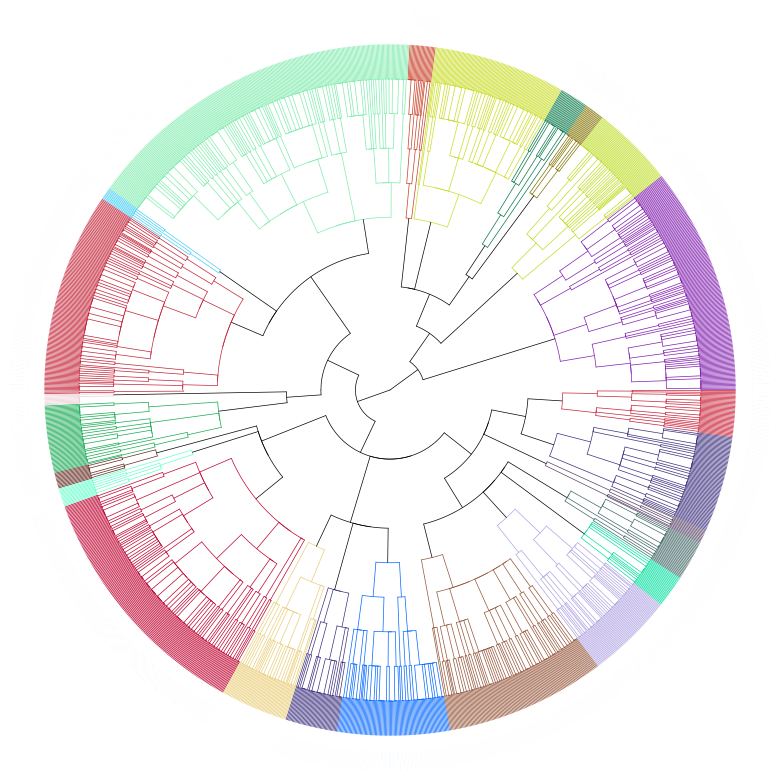

In [52]:
fig,ax = plt.subplots(figsize = (10,10))
radialTreee(rZ,ax = ax,colorlabels = plot_colors_dict,colorlabels_legend =plot_colors_legends,pallete = cluster_color_dict,addlabels =False,alpha = 1,linewidth = 0.5)
fig.savefig('./figures/pbmc.st.tree.pdf')
fig.show()

# stat read count

In [53]:
from statsmodels.stats.multitest import multipletests

statresult = []
for cluster in chainpbmccdr3df['cluster'].unique():
    subchainpbmccdr3df = chainpbmccdr3df[chainpbmccdr3df['cluster'] == cluster]
    subtmpdf = pbmcdf[pbmcdf['clonename'].isin(subchainpbmccdr3df['clonename'])]
    subtmpdf = subtmpdf[['read_count_p','aaSeqCDR3','p','group']].copy()
    active_tb_data = subtmpdf[subtmpdf['group'] == 'Active_TB']['read_count_p']
    control_data = subtmpdf[subtmpdf['group'] == 'Control']['read_count_p']
    ma = np.mean(active_tb_data)
    mc = np.mean(control_data)
    s,p = ttest_ind(active_tb_data, control_data)
    statresult.append([cluster,s,p,ma,mc])
statresult = pd.DataFrame(statresult,columns = ['cluster','s','p','Active_TB','Control']).sort_values('p')
_, q_values, _, _ = multipletests(statresult['p'], method='fdr_bh')
statresult['qvalue'] = q_values

In [54]:
order = statresult.sort_values('qvalue')['cluster'].astype(str)

In [55]:
statresult['cluster'] = pd.Categorical(statresult['cluster'].astype(str) ,categories=order ,ordered=True)

In [56]:
statresult['fold'] = np.log(statresult['Active_TB']/statresult['Control'])
statresult['-logq'] = -np.log10(statresult['qvalue'])

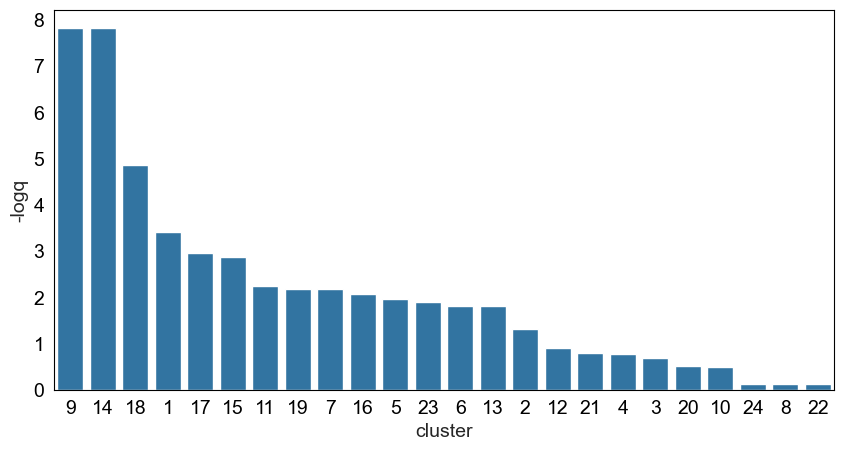

In [67]:
fig,ax = plt.subplots(figsize = (10,5))
sns.barplot(data = statresult, x = 'cluster',y = '-logq')
ax.grid(False)
fig.savefig('./figures/pbmc.rank.pdf')

In [58]:
statresult[statresult['qvalue']<0.05]

cluster         s             p  Active_TB   Control        qvalue  \
2        9  6.136917  9.786410e-10   0.004155  0.003130  1.485423e-08   
11      14  6.096941  1.237852e-09   0.003725  0.002775  1.485423e-08   
8       18  4.798338  1.761016e-06   0.003359  0.002481  1.408813e-05   
14       1  4.001385  6.515830e-05   0.003600  0.002918  3.909498e-04   
3       17  3.696438  2.282908e-04   0.004115  0.003105  1.095796e-03   
12      15  3.616679  3.348712e-04   0.003540  0.002484  1.339485e-03   
21      11  3.161521  1.643743e-03   0.003204  0.002495  5.635690e-03   
13      19  3.068399  2.224768e-03   0.004099  0.002962  6.628630e-03   
1        7  3.027676  2.485736e-03   0.003695  0.002926  6.628630e-03   
10      16  2.937519  3.496562e-03   0.003016  0.002254  8.391748e-03   
18       5  2.815858  4.937519e-03   0.004356  0.003407  1.077277e-02   
6       23  2.727693  6.473578e-03   0.003704  0.003068  1.294716e-02   
0        6  2.661779  8.505327e-03   0.004232  0.002799  1.565300e-02   
16      13  2.673824  9.130919e-03   0.003215  0.001952  1.565300e-02   
20       2  2.178506  2.964023e-02   0.006391  0.003862  4.742437e-02   

        fold     -logq  
2   0.283349  7.828150  
11  0.294432  7.828150  
8   0.302805  4.851147  
14  0.210105  3.407879  
3   0.281627  2.960270  
12  0.354158  2.873062  
21  0.249982  2.249053  
13  0.324776  2.178576  
1   0.233372  2.178576  
10  0.291030  2.076148  
18  0.245698  1.967673  
6   0.188458  1.887826  
0   0.413260  1.805402  
16  0.499102  1.805402  
20  0.503717  1.323998

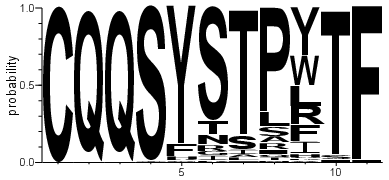

In [59]:
subchainpbmccdr3df = chainpbmccdr3df[chainpbmccdr3df['cluster'] == 9]
align_seq(subchainpbmccdr3df['aaSeqCDR3'],'pbmc_top_9',max_lenth = None,plot = True)

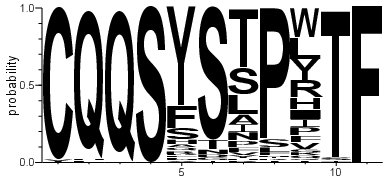

In [60]:
clusterdf = clonedf[clonedf['cluster'] == 49]
align_seq(clusterdf['CDR3'],'tbst_49',max_lenth = None,plot = True)

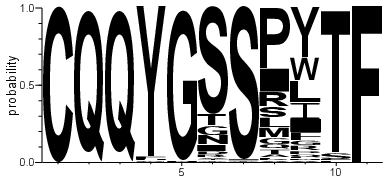

In [61]:
subchainpbmccdr3df = chainpbmccdr3df[chainpbmccdr3df['cluster'] == 14]
align_seq(subchainpbmccdr3df['aaSeqCDR3'],'pbmc_top_14',max_lenth = None,plot = True)

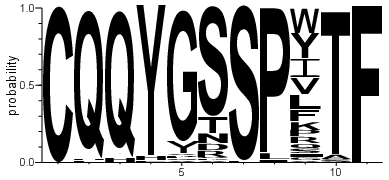

In [62]:
clusterdf = clonedf[clonedf['cluster'] == 95]
align_seq(clusterdf['CDR3'],'tbst_95',max_lenth = None,plot = True)

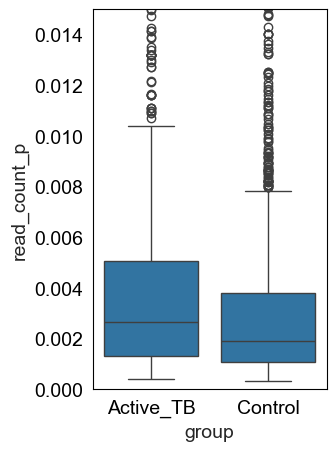

In [63]:
subchainpbmccdr3df = chainpbmccdr3df[chainpbmccdr3df['cluster'] == 9]
subdf = pbmcdf[pbmcdf['clonename'].isin(subchainpbmccdr3df['clonename'])]
subdf = subdf[['read_count_p','aaSeqCDR3','p','group']].copy()
fig,ax = plt.subplots(figsize = (3,5))
sns.boxplot(data = subdf[subdf['group'].isin(['Active_TB','Control'])], x = 'group', y= 'read_count_p',ax = ax)
ax.grid(False)
ax.set_ylim(0,0.015)
fig.savefig('./figures/cluster9.pbmc.pdf')
fig.show()

In [64]:
from scipy.stats import ttest_ind
active_tb_data = subdf[subdf['group'] == 'Active_TB']['read_count_p']
control_data = subdf[subdf['group'] == 'Control']['read_count_p']
ttest_ind(active_tb_data,control_data)

TtestResult(statistic=6.136917033580154, pvalue=9.786410189946745e-10, df=2445.0)

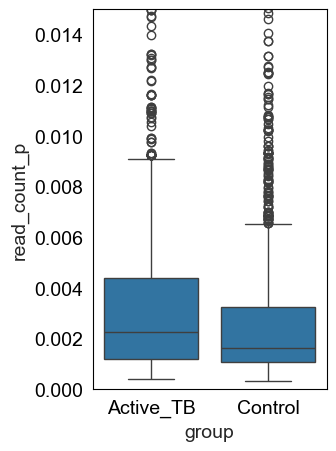

In [65]:
subchainpbmccdr3df = chainpbmccdr3df[chainpbmccdr3df['cluster'] == 14]
subdf = pbmcdf[pbmcdf['clonename'].isin(subchainpbmccdr3df['clonename'])]
subdf = subdf[['read_count_p','aaSeqCDR3','p','group']].copy()
fig,ax = plt.subplots(figsize = (3,5))
sns.boxplot(data = subdf[subdf['group'].isin(['Active_TB','Control'])], x = 'group', y= 'read_count_p',ax = ax)
ax.grid(False)
ax.set_ylim(0,0.015)
fig.savefig('./figures/cluster14.pbmc.pdf')
fig.show()

In [66]:
from scipy.stats import ttest_ind
active_tb_data = subdf[subdf['group'] == 'Active_TB']['read_count_p']
control_data = subdf[subdf['group'] == 'Control']['read_count_p']
ttest_ind(active_tb_data,control_data)

TtestResult(statistic=6.096941283887715, pvalue=1.237852098254468e-09, df=2664.0)

In [70]:
vc = clonedf.value_counts('cluster')
print(f'total: {clonedf.shape[0]}, cluster: {vc.shape[0]}')
vc = chainpbmccdr3df.value_counts('cluster')
print(f'total: {chainpbmccdr3df.shape[0]}, cluster: {vc.shape[0]}')

total: 2923, cluster: 159
total: 1722, cluster: 24


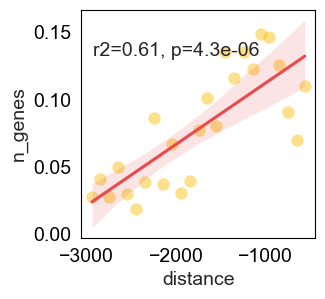

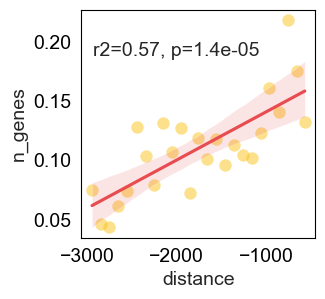

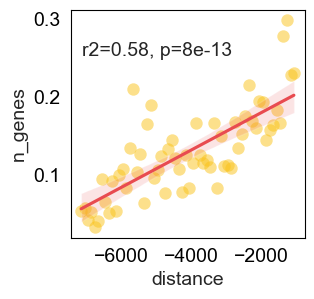

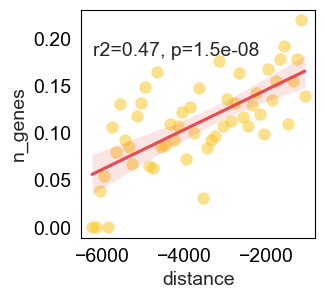

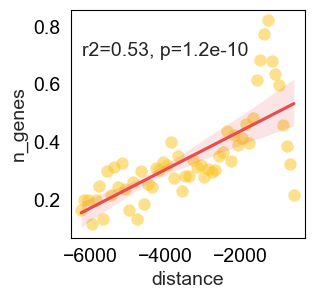

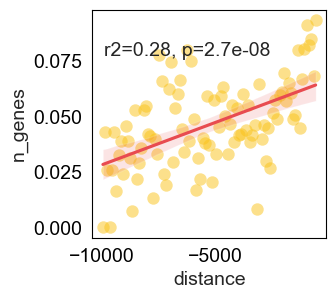

In [78]:
distance_range = {
    'F1':(-500,-3000),  
    'F3':(-500,-3000), 
    'C1':(-1000,-10000),
    'D5':(-1000,-10000),   
    'A3':(-500,-10000), 
    'C3':(-500,-10000)
}

for sample,imudata in imudatadict.items():
    max_distance,min_distance = distance_range[sample]
    obsdf = imudata.obs[['distance','n_genes']].copy()
    obsdf = obsdf[(obsdf['distance'] < max_distance) & (obsdf['distance'] > min_distance)].copy()
    step = 100
    obsdf['dist_range'] = obsdf['distance']//step * step
    df_mean = obsdf.groupby('dist_range').mean().reset_index()
    pearsonr_corr, p_value = pearsonr(df_mean['distance'], df_mean['n_genes'])
    fig,ax = plt.subplots(figsize = (3,3))
    regplot(df_mean,x = 'distance',y = 'n_genes',ax =ax)
    fig.savefig(f'./figures/{sample}.clonetype.pdf')
    fig.show()